# Image Processing

## Libraries Used

- `PIL`: The Python Imaging Library (PIL) adds image processing capabilities to your Python interpreter.
- `numpy`: NumPy is the fundamental package for scientific computing with Python.
- `random`: This module implements pseudo-random number generators for various distributions.
- `matplotlib.pyplot`: Matplotlib is a plotting library for the Python programming language and its numerical mathematics extension NumPy.


In [1]:
from PIL import Image
import numpy as np
import random
import matplotlib.pyplot as plt

## Loading Images

loading the given images using the PIL library to perform further image processing tasks.

Each `Image.open()` function call opens required image file in PNG format and creates an `Image` object.

In [2]:
img1=Image.open('1.png')
img2=Image.open('2.png')
img3=Image.open('3.png')
img4=Image.open('4.png')

## Converting Images to Arrays

Converting PIL Image objects into NumPy arrays, which is a common step in image processing as it allows for manipulation of pixel data.

By calling `np.array()`, we are converting the `Image` objects into NumPy arrays. This conversion is necessary for the pixel-level operations that might follow, such as image filtering, transformation, or analysis.

In [3]:
img1_array = np.array(img1)
img2_array = np.array(img2)
img3_array = np.array(img3)
img4_array = np.array(img4)

## Image Array Dimensions

Understanding the dimensions of the image arrays is crucial for further image analysis and processing tasks.


In [4]:
print(img1_array.shape)

(64, 64, 4)


# Preparing Image Data for K-means Clustering

We prepare the image data for K-means clustering by converting the color images to grayscale. K-means clustering is typically applied to two-dimensional data, so we need to reduce the dimensionality of our image arrays.

## Understanding the Image Array

The `img1_array` is a NumPy array representing an image with the shape `(64, 64, 4)`. This indicates that the image is 64 pixels in height, 64 pixels in width, and has 4 channels. The four channels likely represent Red, Green, Blue, and an Alpha channel for transparency.

In [5]:
grayscale_img1 = img1_array[:,:,0]
grayscale_img2 = img2_array[:,:,0]
grayscale_img3 = img3_array[:,:,0]
grayscale_img4 = img4_array[:,:,0]

Before applying K-means clustering, we convert the image to grayscale and reduce the shape from `(64, 64, 4)` to `(64, 64)` by selecting only one channel from the array:

- `grayscale_img1 = img1_array[:,:,0]`: This line extracts the first channel (Red channel) from the `img1_array` and creates a two-dimensional grayscale image `grayscale_img1`.

- K-means clustering algorithm works by finding groups (or clusters) in the data, with the number of groups represented by the variable K. When applied to image segmentation, K-means clustering can partition the pixels in the image into clusters based on their intensity values.

By converting an image to grayscale, we simplify the problem for K-means clustering by reducing the feature space from three color channels to just one intensity channel. This makes the algorithm more efficient and easier to apply, as it only needs to consider the intensity of the pixels rather than the full color spectrum.

In [6]:
print(grayscale_img1.shape)

(64, 64)


# K-Means Clustering Function

The `k_means_clustering` function is designed to perform K-means clustering on a grayscale image. This unsupervised machine learning algorithm aims to partition `n` observations into `k` clusters in which each observation belongs to the cluster with the nearest mean.

## Parameters
- `grayscale_img`: A 2D NumPy array representing the grayscale image.
- `k`: The number of desired clusters.
- `max_iterations`: The maximum number of iterations to run the algorithm (default is 10).
- `tolerance`: The convergence tolerance. If the change in centroids is less than this value, the algorithm will terminate (default is 0.01).

## Algorithm Steps
1. **Initialization**: Randomly select `k` centroids from the non-zero points of the image.
2. **Assignment**: Assign each point to the nearest centroid.
3. **Update**: Calculate the new centroids as the mean of the points assigned to each cluster.
4. **Convergence Check**: If the centroids do not change by more than the `tolerance` or the `max_iterations` are reached, the algorithm stops.

In [30]:
def k_means_clustering(grayscale_img, k, max_iterations=10, tolerance=0.01):
    # Flattening the image to get the list of light points
    points = np.column_stack(np.where(grayscale_img > 0))
    
    # Step 1: Initializing K cluster centroids randomly
    centroids = points[random.sample(range(len(points)), k)]
    
    for iteration in range(max_iterations):
        # Step 2a: Assigning each data point to the nearest centroid
        clusters = {i: [] for i in range(k)}
        for point in points:
            distances = [np.linalg.norm(point - centroid) for centroid in centroids]
            min_distance_index = distances.index(min(distances))
            clusters[min_distance_index].append(point)
        
        # Step 2b: Recomputing the centroids as the mean of the data points assigned to each centroid
        new_centroids = []
        for i in range(k):
            cluster_points = clusters[i]
            if cluster_points:  # Avoiding division by zero
                new_centroid = np.mean(cluster_points, axis=0)
                new_centroids.append(new_centroid)
            else:  # If a centroid has no points, reinitializing it randomly
                new_centroids.append(points[random.randint(0, len(points) - 1)])
        
        # Step 2c: Checking for convergence criteria
        if all(np.linalg.norm(new_centroids[i] - centroids[i]) < tolerance for i in range(k)):
            break
        
        centroids = new_centroids
    
    # Step 3: Returning the final centroids and cluster assignments
    return centroids, clusters

# Compute Within-Cluster Sum of Squares (WCSS)

The `compute_wcss` function calculates the within-cluster sum of squares (WCSS), which is a measure of the variance within each cluster in K-means clustering. A lower WCSS indicates that the clusters are tighter and more defined.

## Parameters
- `grayscale_img`: A 2D NumPy array representing the grayscale image.
- `centroids`: A list of centroid coordinates for each cluster.
- `clusters`: A dictionary where each key is a cluster index and each value is a list of data points assigned to that cluster.
  
## WCSS Calculation
The function iterates over each cluster and computes the sum of squared distances between each data point and the cluster’s centroid

## Importance of WCSS
WCSS is an important metric used to determine the optimal number of clusters (K) by the Elbow method. By plotting the WCSS against different values of K, you can observe the point where the rate of decrease sharply changes, indicating the appropriate number of clusters for the data.

In [8]:
def compute_wcss(grayscale_img, centroids, clusters):
    wcss = 0
    for k in clusters.keys():
        wcss += sum(np.linalg.norm(data_point - centroids[k]) ** 2 for data_point in clusters[k])
    return wcss

## Function: elbow_method

The `elbow_method` function is designed to help determine the optimal number of clusters for k-means clustering by plotting the Within-Cluster Sum of Square (WCSS) against the number of clusters (k). This method is useful in identifying the 'elbow point' where the rate of decrease in WCSS sharply changes, indicating a suitable number of clusters for the data.

### Parameters:
- `grayscale_img`: A grayscale image array on which k-means clustering is performed.
- `max_clusters`: The maximum number of clusters to consider.
- `idx`: An index or identifier for the map.

### Returns:
This function does not return a value but displays a plot of WCSS values for different numbers of clusters.

In [9]:
def elbow_method(grayscale_img, max_clusters,idx):
    wcss_values = []
    for k in range(1, max_clusters + 1):
        wcss = [compute_wcss(grayscale_img, *k_means_clustering(grayscale_img, k)) for i in range(10)]
        wcss_values.append(min(wcss))
    
    plt.figure(figsize=(8, 4))
    plt.plot(range(1, max_clusters + 1), wcss_values, 'bx-')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
    plt.title(f"Map {idx}")
    plt.show()

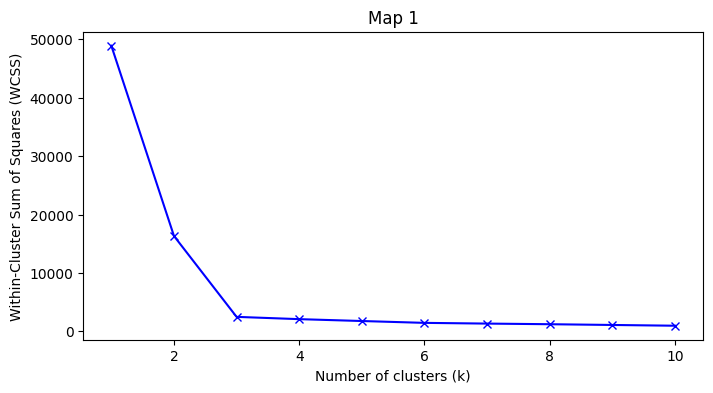

In [10]:
elbow_method(grayscale_img1, max_clusters=10,idx=1)
#The optimal number of clusters for the given data is 3.

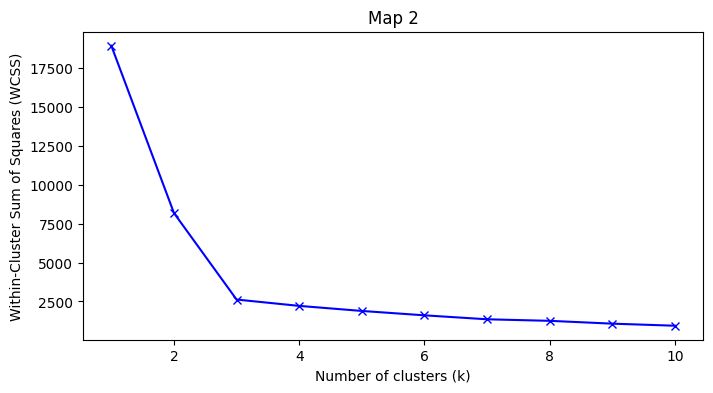

In [11]:
elbow_method(grayscale_img2, max_clusters=10,idx=2)
#The optimal number of clusters for the given data is 3.

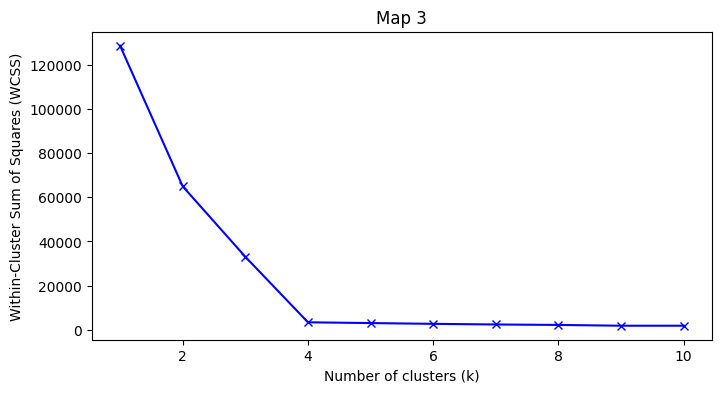

In [12]:
elbow_method(grayscale_img3, max_clusters=10,idx=3)
#The optimal number of clusters for the given data is 4.

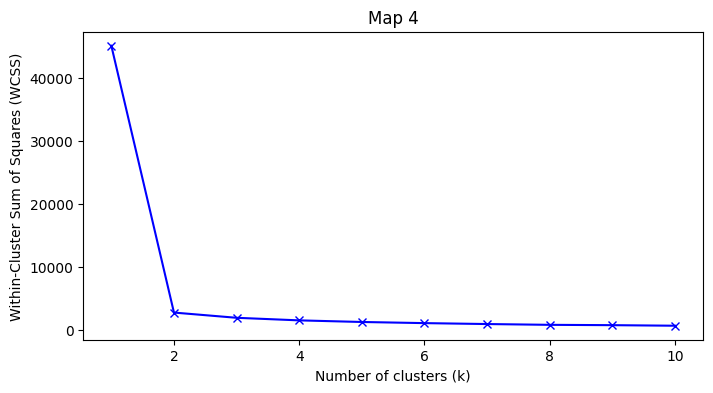

In [13]:
elbow_method(grayscale_img4, max_clusters=10,idx=4)
#The optimal number of clusters for the given data is 2.

## K-Means Clustering Execution

The following lines of code execute the k-means clustering algorithm on the four given grayscale images. Each line corresponds to a different image and specifies the number of clusters to identify within that image.

### Code and Parameters:
- `centroids1, clusters1 = k_means_clustering(grayscale_img1, 3)`: This line applies k-means clustering to `grayscale_img1` and aims to find **3 clusters**. The resulting centroids and cluster assignments are stored in `centroids1` and `clusters1`, respectively.
- `centroids2, clusters2 = k_means_clustering(grayscale_img2, 3)`: Similar to the first line, this applies the algorithm to `grayscale_img2` with **3 clusters**, storing the output in `centroids2` and `clusters2`.
- `centroids3, clusters3 = k_means_clustering(grayscale_img3, 4)`: This line processes `grayscale_img3` to find **4 clusters**, with the results in `centroids3` and `clusters3`.
- `centroids4, clusters4 = k_means_clustering(grayscale_img4, 2)`: Finally, `grayscale_img4` is clustered into **2 groups**, with `centroids4` and `clusters4` holding the output.

In [31]:
centroids1,clusters1=k_means_clustering(grayscale_img1,3)
centroids2,clusters2=k_means_clustering(grayscale_img2,3)
centroids3,clusters3=k_means_clustering(grayscale_img3,4)
centroids4,clusters4=k_means_clustering(grayscale_img4,2)

## Function: `cluster_plot`

This function visualizes clusters and their centroids on a 2D plot. Each cluster is represented by a distinct color, and the centroids are marked with a square symbol. Lines connect the centroids to illustrate their relative positions.

### Parameters:
- `centroids`: A dictionary where the key is the centroids index and the value is a list representing the centroid's coordinates.
- `clusters`: A dictionary where the key is the cluster index and the value is a list of points belonging to that cluster, with each point being a list of coordinates.
- `idx`: An integer or string that uniquely identifies the plot, used in the plot title.
  
### Visualization:

- The plot is set to a fixed size of 8x8 inches.
- Each cluster is plotted in a unique color: red, blue, green, and yellow.
- Centroids are marked with a square symbol with black edges and a white fill.
- A label is added to each centroid indicating its cluster index.
- Lines between centroids are drawn in black to show the relationship between clusters.
- The plot is titled "Map{idx}" where `idx` is the passed identifier.
- The x-axis ticks are placed at the top of the plot.
- The y-axis is inverted with a range from 64 to 0.
- The x-axis has a range from 0 to 64.

In [32]:
def cluster_plot(centroids, clusters, idx):
    color = ['red', 'blue', 'green', 'yellow']
    plt.figure(figsize=(8, 8))
    for i in range(len(clusters.keys())):
        cluster = np.array(clusters[i])
        plt.scatter(cluster[:, 1], cluster[:, 0], c=color[i], label=f'Cluster {i}')
        # Plot centroids with black edges and white fill
        plt.scatter(centroids[i][1], centroids[i][0], edgecolor='black', facecolor='white', marker='s', s=100)
        # Add index numbers with the color of the cluster
        plt.text(centroids[i][1], centroids[i][0], str(i), color=color[i], ha='center', va='center', fontsize=10, fontweight='bold')
    for i in range(len(centroids)):
        for j in range(i + 1, len(centroids)):
            plt.plot([centroids[i][1], centroids[j][1]], [centroids[i][0], centroids[j][0]], c='black')
    plt.title(f"Map{idx}")
    plt.gca().xaxis.tick_top()
    plt.ylim(64, 0)
    plt.xlim(0, 64)
    plt.legend()
    plt.show()

## Function: `distance`

The `distance` function calculates and displays the pairwise Euclidean distances between clusters' centroids obtained from k-means clustering.

### Parameters:
- `final_centroids`: A list of centroids where each centroid is represented as a list or array of coordinates.

### Behavior:
- The function computes the Euclidean distance between each unique pair of centroids.
- It avoids redundant calculations and self-comparisons.
- The distances are rounded to two decimal places for clarity.
- A table is created and displayed within the plot area, showing the distances between each pair of clusters.

In [33]:
def distance(final_centroids):
    #'final_centroids' is an array of centroids coordinates from k-means clustering
    # Calculating the distances between each pair of centroids
    distances = np.zeros((len(final_centroids), len(final_centroids)))

    for i, centroid_i in enumerate(final_centroids):
        for j, centroid_j in enumerate(final_centroids):
            if i < j:  # To avoid repetition and self-comparison
                distances[i][j]=np.linalg.norm(centroid_i-centroid_j)

    # Preparing the table data
    table_data = []
    for i in range(len(final_centroids)):
        for j in range(i+1, len(final_centroids)):
            row_label = f"Cluster {i+1} and Cluster {j+1}"
            distance_value = distances[i][j].round(2)
            table_data.append([row_label, distance_value])

    # Defining column headers
    col_labels = ['Clusters', 'Distance']

    # Plotting the table
    fig, ax = plt.subplots(figsize=(1, 1))
    ax.axis('off')
    ax.axis('tight')

    # Creating the table
    table = ax.table(cellText=table_data, colLabels=col_labels, loc='left', cellLoc='center')

    # Adjusting the table properties
    table.auto_set_font_size(False)
    table.set_fontsize(8)
    table.auto_set_column_width(col=[0, 1])

    plt.show()

## Scatter-Plot and Distance table
- Plotting a cluster plot given the centroids and cluster data of each map using the `cluster_plot` function
- Creating a table showing the distances between different centroids in each given centroid list seperately.

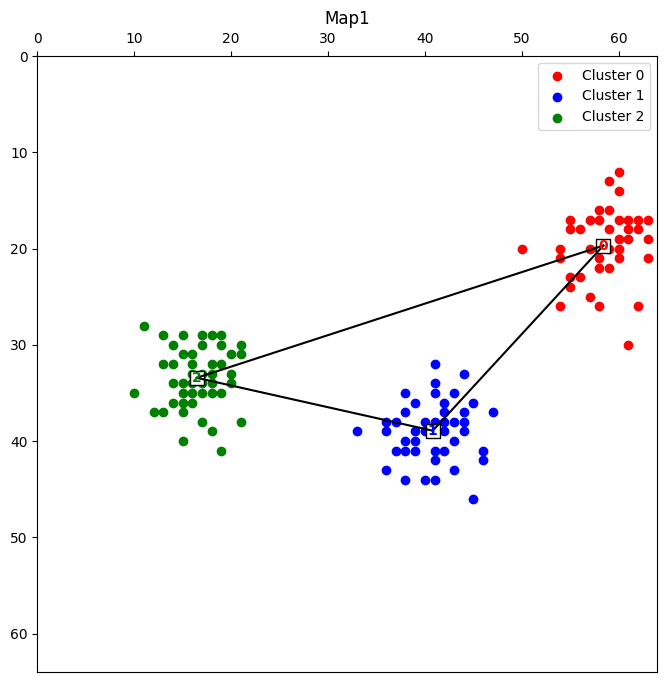

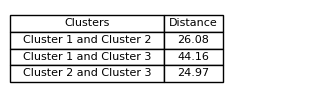

In [26]:
cluster_plot(centroids1,clusters1,idx=1)
distance(centroids1)

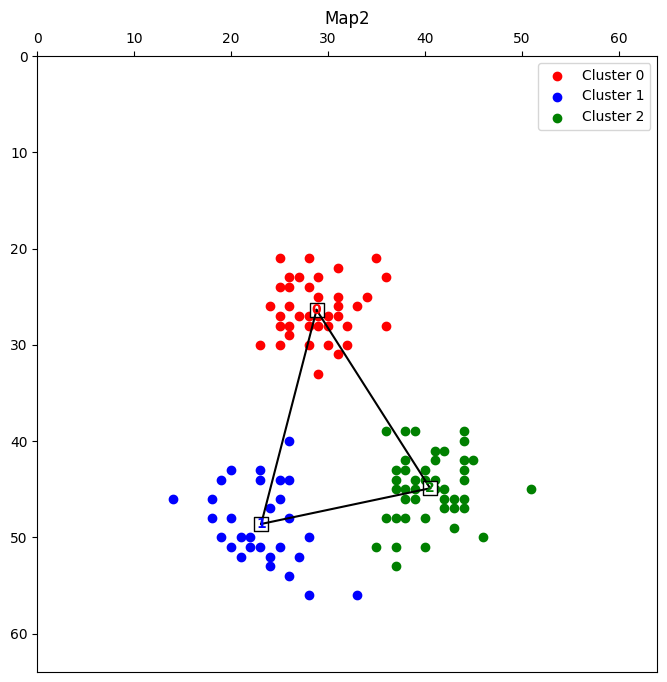

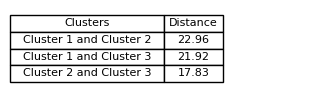

In [34]:
cluster_plot(centroids2,clusters2,idx=2)
distance(centroids2)

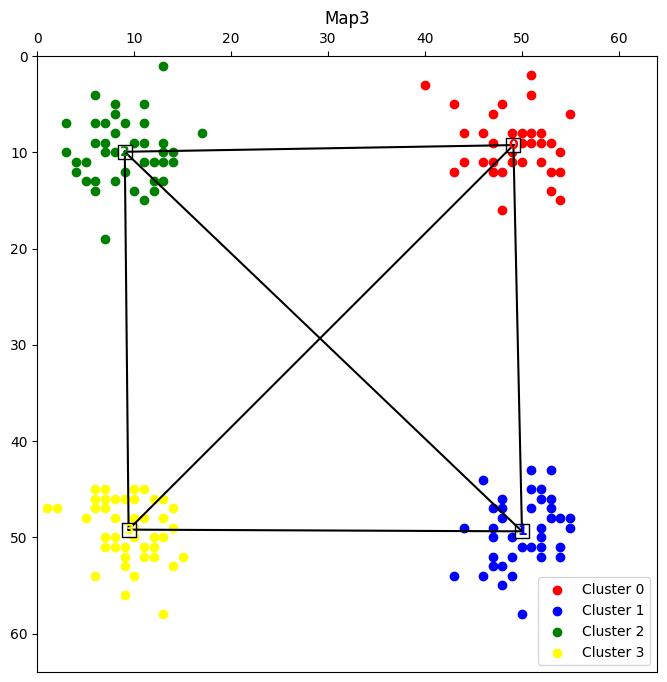

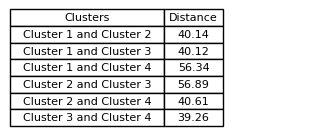

In [35]:
cluster_plot(centroids3,clusters3,idx=3)
distance(centroids3)

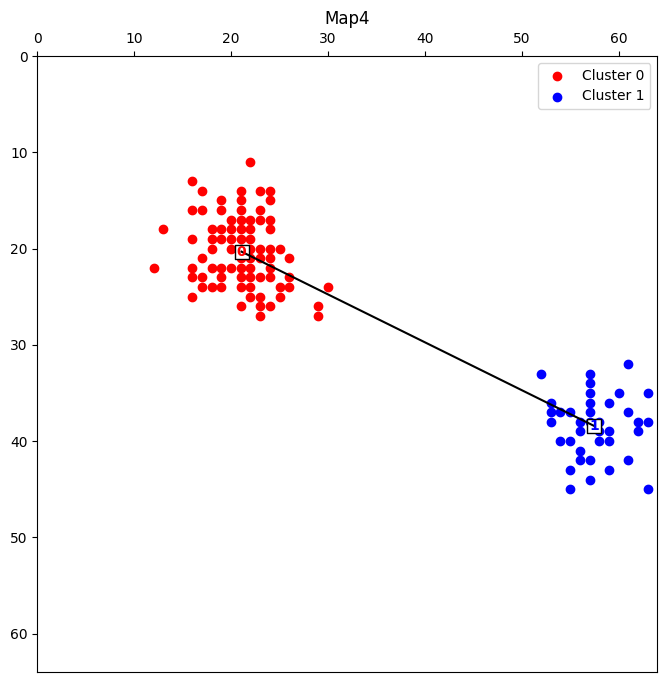

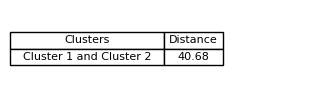

In [36]:
cluster_plot(centroids4,clusters4,idx=4)
distance(centroids4)